In [83]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import seaborn as sns

In [88]:
sns.set_style(rc = {'axes.facecolor': '#E8EFEF','figure.facecolor':'#E8EFEF'})

In [74]:
url = r"https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
df = pd.read_csv(url,encoding='latin1')

In [75]:
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [78]:
X = df.drop(["status","name"],axis=1).copy()
y = df["status"].copy()

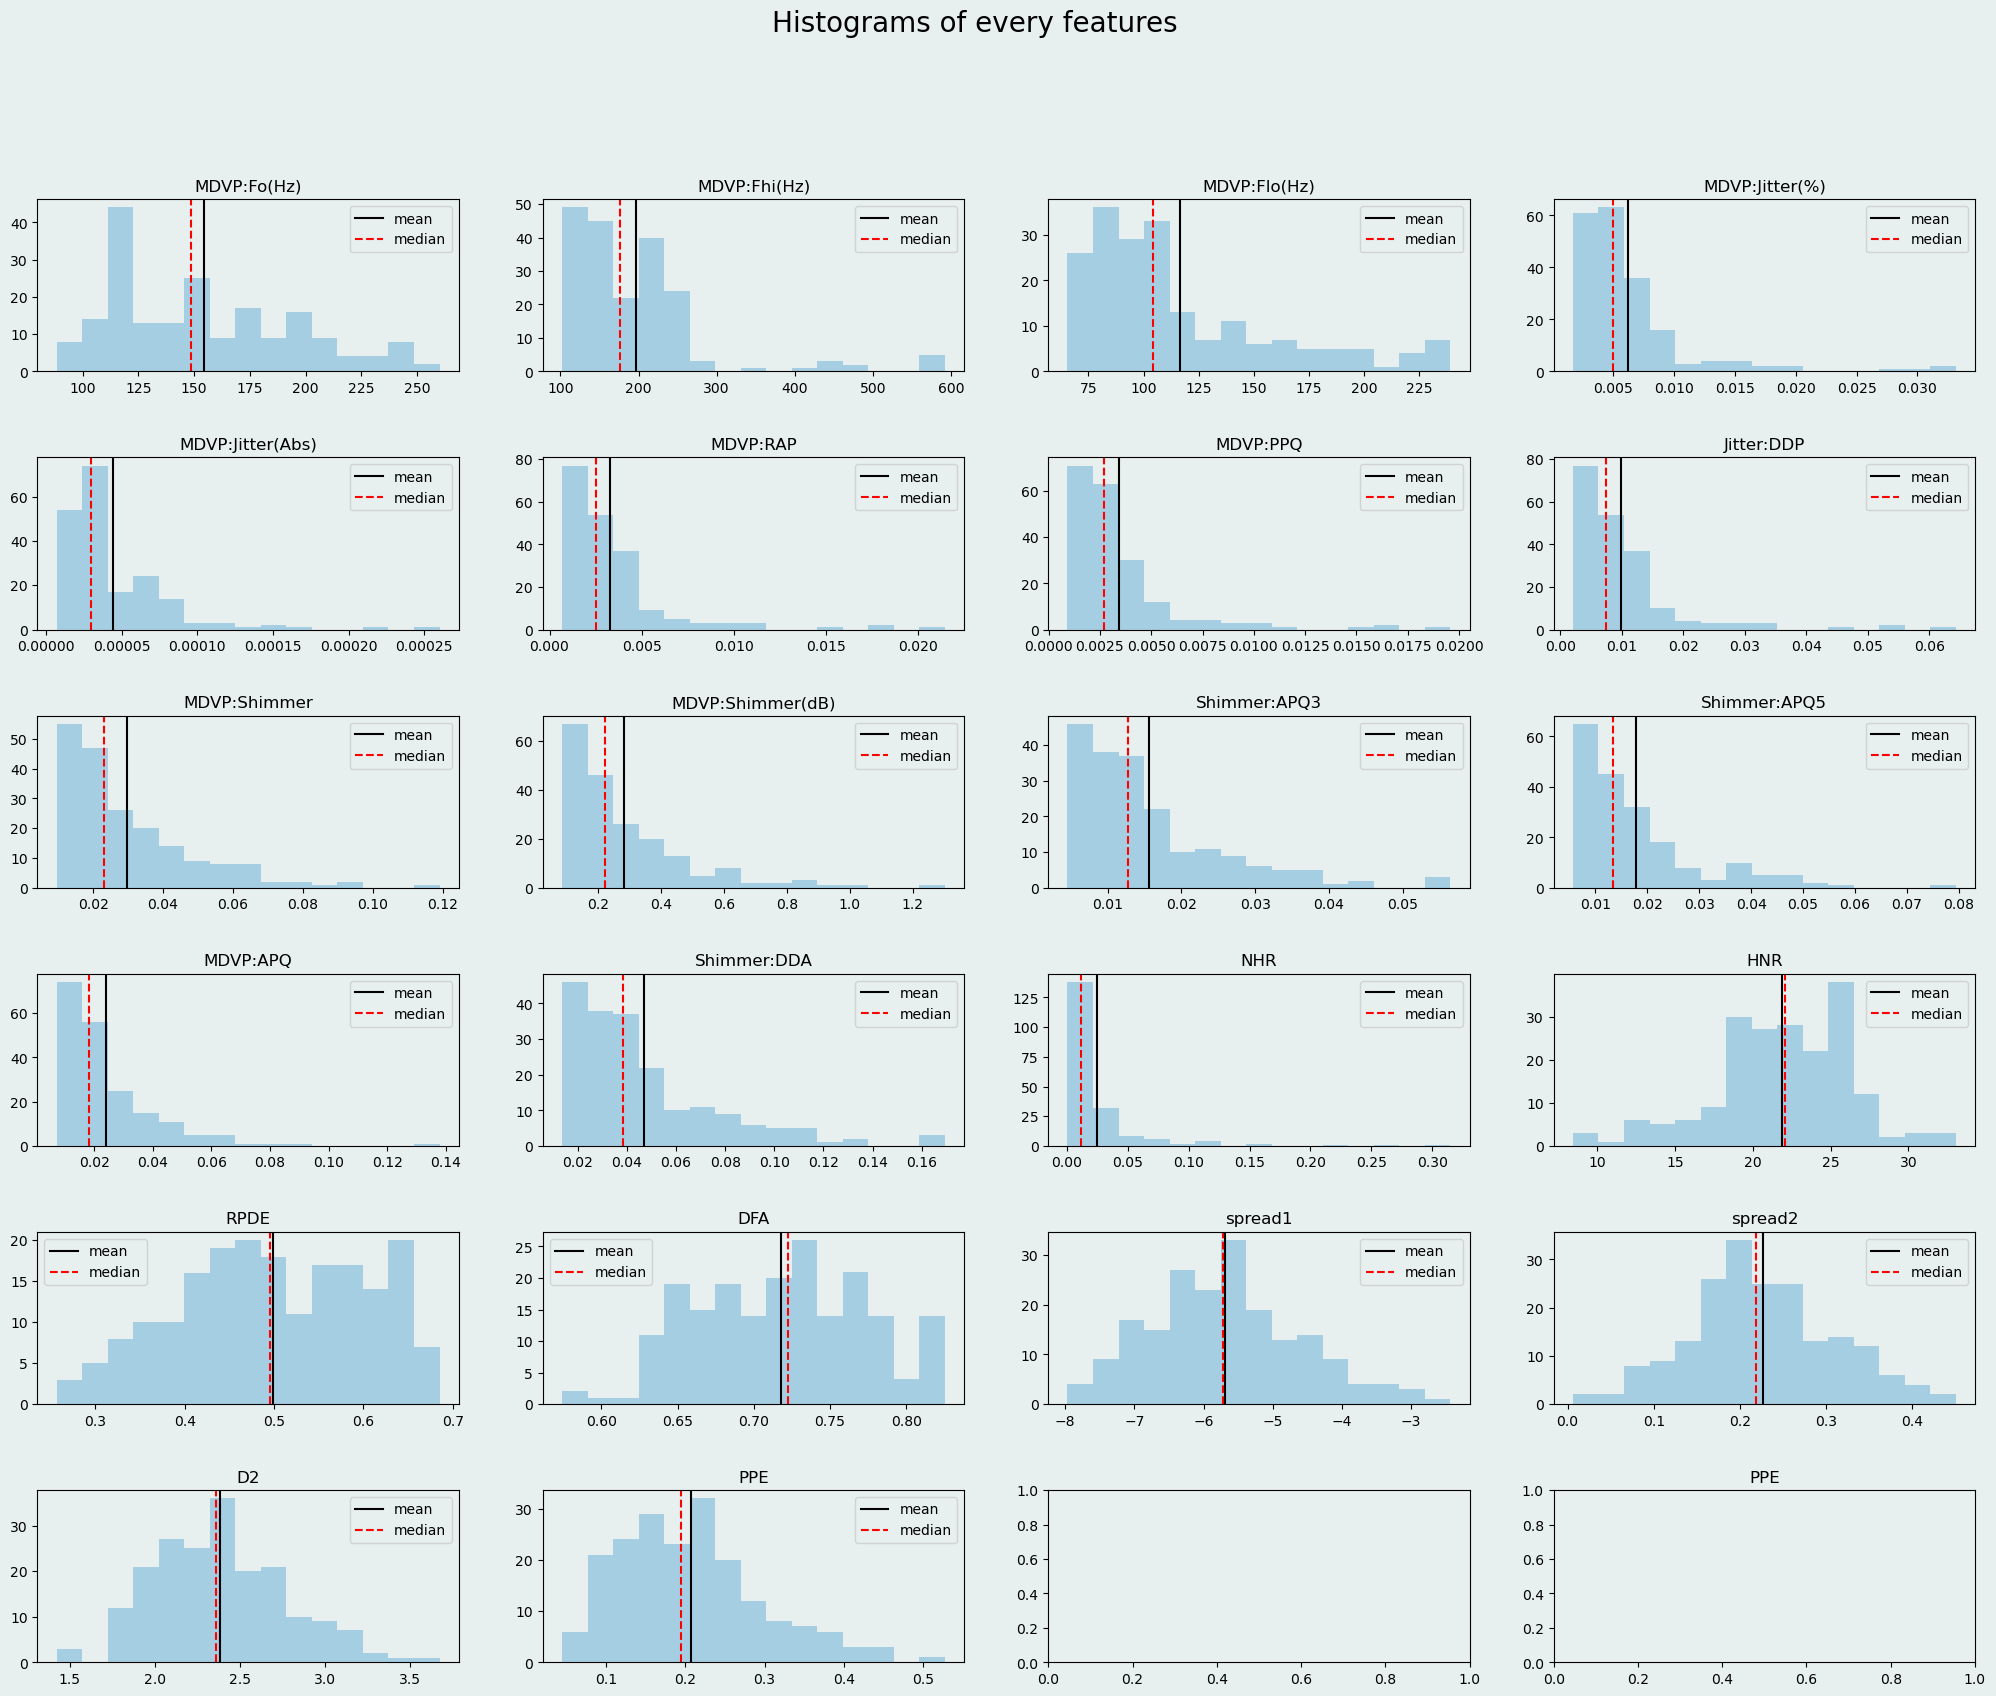

In [104]:
sns.set_palette("Paired")
fig,ax = plt.subplots(nrows = 6, ncols = 4,figsize=(25,19))
plt.subplots_adjust(hspace=0.5)
count = 0
columns = X.columns
for col, axes in zip(columns,ax.ravel()):
    plt.title(f"{col}")
    axes.hist(X[col],bins=15)
    mean = X[col].mean()
    median = X[col].median()
    axes.axvline(mean, color='k', linestyle='-',label="mean")
    axes.set_title(f"{col}")
    axes.axvline(median, color='r', linestyle='--',label="median")
    axes.legend()
plt.suptitle("Histograms of every features",fontsize=20);

In [52]:
# Feature selection using Variance Thresholding
X_scaled = MinMaxScaler().fit_transform(X)
sel = VarianceThreshold(threshold=0.01)
sel.fit(X)
selected_columns = sel.get_support()
X = X.loc[:,selected_columns]
X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Shimmer(dB),HNR,RPDE,spread1,D2
0,119.992,157.302,74.997,0.426,21.033,0.414783,-4.813031,2.301442
1,122.400,148.650,113.819,0.626,19.085,0.458359,-4.075192,2.486855
2,116.682,131.111,111.555,0.482,20.651,0.429895,-4.443179,2.342259
3,116.676,137.871,111.366,0.517,20.644,0.434969,-4.117501,2.405554
4,116.014,141.781,110.655,0.584,19.649,0.417356,-3.747787,2.332180


In [55]:
# Scalling the values using standard scaler
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,stratify=y,random_state=0)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model Building

In [64]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
model = SVC(C=100,kernel="rbf")
cv = cross_val_score(model,
                     X_train,
                     y_train,
                     scoring="accuracy",
                     cv=10,
                     n_jobs=-1,
                     verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [69]:
print(f"➡️Cross validation training score : {cv.mean()}")

Cross validation training score : 0.89


In [70]:
model.fit(X_train,y_train)

SVC(C=100)

In [100]:
print(f"➡️Testing score is : {model.score(X_test,y_test):.2f}")
print(f"➡️f1 score is : {f1_score(y_test,model.predict(X_test)):.2f}")

➡️Testing score is : 0.96
➡️f1 score is : 0.97


<AxesSubplot:>

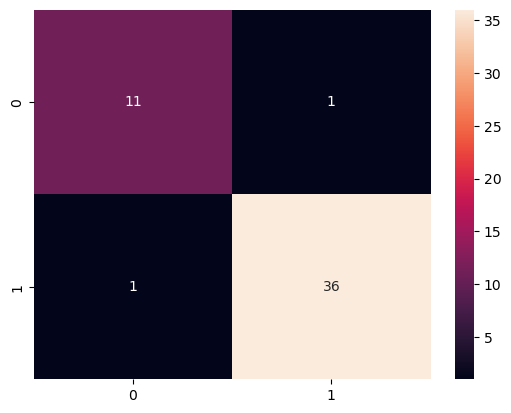

In [84]:
metric = confusion_matrix(y_test,model.predict(X_test))
sns.heatmap(metric,annot=True,fmt=".0f")

Text(0.5, 0.98, 'ROC curve comparison')

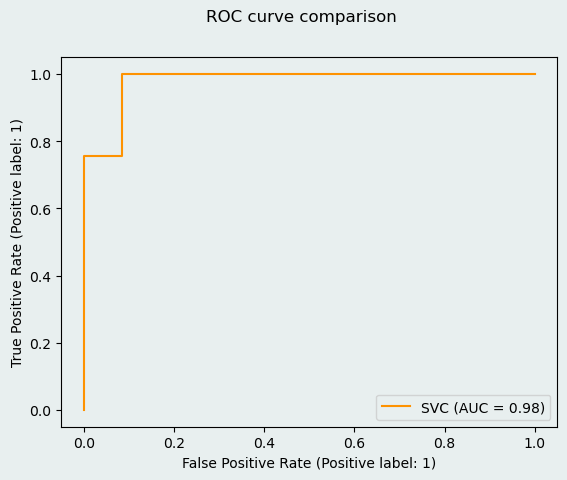

In [96]:
sns.set_palette("Wistia_r")
svc_disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
svc_disp.figure_.suptitle("ROC curve comparison")